# Mono-Dimensional Signal Processing

Physiological signal analysis focuses on interpreting signals generated by the human body, such as Electrocardiograms (ECG). In this case, ECG analysis aims to detect anomalies like arrhythmias (irregular heartbeats) or classify heart conditions. This is critical for early diagnosis and timely medical interventions.

## Set Up Environment

### Install necessary libraries.

In [7]:
!pip install tensorflow numpy pandas matplotlib scikit-learn wfdb kaggle
!pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Load the dataset from Kaggle.

https://www.kaggle.com/datasets/mondejar/mitbih-database

I am using kaggle API to fetch the dataset. So we need to upload the `kaggle.json` file to use it.

In [4]:
# Upload your Kaggle API key (kaggle.json) to Colab.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Use the Kaggle API to download the dataset
!kaggle datasets download -d mondejar/mitbih-database
!unzip mitbih-database.zip -d mitbih

Dataset URL: https://www.kaggle.com/datasets/mondejar/mitbih-database
License(s): CC0-1.0
 94% 271M/288M [00:02<00:00, 116MB/s]
100% 288M/288M [00:03<00:00, 101MB/s]
Archive:  mitbih-database.zip
  inflating: mitbih/100.csv          
  inflating: mitbih/100annotations.txt  
  inflating: mitbih/101.csv          
  inflating: mitbih/101annotations.txt  
  inflating: mitbih/102.csv          
  inflating: mitbih/102annotations.txt  
  inflating: mitbih/103.csv          
  inflating: mitbih/103annotations.txt  
  inflating: mitbih/104.csv          
  inflating: mitbih/104annotations.txt  
  inflating: mitbih/105.csv          
  inflating: mitbih/105annotations.txt  
  inflating: mitbih/106.csv          
  inflating: mitbih/106annotations.txt  
  inflating: mitbih/107.csv          
  inflating: mitbih/107annotations.txt  
  inflating: mitbih/108.csv          
  inflating: mitbih/108annotations.txt  
  inflating: mitbih/109.csv          
  inflating: mitbih/109annotations.txt  
  inflating: m

In [8]:
# Install necessary libraries
!pip install tensorflow numpy pandas matplotlib scikit-learn wfdb kaggle PyWavelets

import os
import shutil

# Create the Kaggle directory if it doesn't exist
kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

# Move the kaggle.json to the correct location
kaggle_json_path = r"C:\Users\ASUS\Desktop\image\kaggle.json"
shutil.copy(kaggle_json_path, os.path.join(kaggle_dir, 'kaggle.json'))

# Set permissions on kaggle.json (works on Windows through Python)
os.chmod(os.path.join(kaggle_dir, 'kaggle.json'), 0o600)

# Use the Kaggle API to download the dataset
!kaggle datasets download -d mondejar/mitbih-database

# Unzip the dataset
import zipfile

with zipfile.ZipFile("mitbih-database.zip", 'r') as zip_ref:
    zip_ref.extractall("C:\\Users\\ASUS\\Desktop\\image\\mitbih")

print("Dataset downloaded and extracted successfully.")


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ASUS\\Desktop\\image\\kaggle.json'

### Import Libraries

In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import pywt
from scipy import stats
from sklearn.utils import resample, compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Concatenate, Masking, LSTM, Dense, Softmax
from tensorflow.keras.models import Model

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

## Explore and Preprocess the Dataset

### Understand the dataset structure.

List all .csv & .txt files in the dataset folder to understand its structure.

Load one of the .csv files and display the first few rows to examine the data.

In [5]:
# Define dataset directory
dataset_dir = "mitbih/mitbih_database"

# List all files in the dataset directory
csv_files = [f for f in os.listdir(dataset_dir) if f.endswith('.csv')]
txt_files = [f for f in os.listdir(dataset_dir) if f.endswith('.txt')]
print("Number of Available CSV Files:", len(csv_files))
print("Number of Available TXT Files:", len(txt_files))
print("--------------------------------------------------------------")
# Load one sample file to explore
sample_file = os.path.join(dataset_dir, csv_files[0])
data = pd.read_csv(sample_file)
data.head()

Number of Available CSV Files: 48
Number of Available TXT Files: 48
--------------------------------------------------------------


,'sample #','MLII','V1'
0,0,932,1050
1,1,932,1050
2,2,932,1050
3,3,932,1050
4,4,932,1050




---



Dynamically identify column names to accommodate varying headers.

In [6]:
# Initialize an empty set to store unique column names
unique_columns = set()

# Iterate through all files to collect column names
for file_name in csv_files:
    file_path = os.path.join(dataset_dir, file_name)
    data = pd.read_csv(file_path)

    # Add column names to the set
    unique_columns.update(data.columns.tolist())

# Convert the set to a sorted list for easier interpretation
unique_columns_list = sorted(unique_columns)

# Display the unique column names
print("Unique Columns Across All Files:")
print(unique_columns_list)

Unique Columns Across All Files:
["'MLII'", "'V1'", "'V2'", "'V4'", "'V5'", "'sample #'"]


Get Records & Annotations

In [7]:
filenames = next(os.walk(dataset_dir))[2]
records=list()
annotations=list()
filenames.sort()

In [8]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    if(file_extension=='.csv'):
        records.append(dataset_dir + '/' +filename + file_extension)
    else:
        annotations.append(dataset_dir + '/' +filename + file_extension)

In [9]:
records[0]

'mitbih/mitbih_database/100.csv'

In [10]:
annotations[0]

'mitbih/mitbih_database/100annotations.txt'

#### Show a sample

In [11]:
temp_signal=[]
with open(records[7],'r') as csvfile:
    filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
    row_index = -1
    for row in filereader:
        if(row_index >= 0):
            temp_signal.insert(row_index, int(row[1]))
        row_index += 1

In [12]:
temp_signal[:12]

[615, 615, 615, 615, 615, 606, 596, 583, 570, 556, 543, 531]

Denoising

We will use Wavelet	because it's good for non-stationary signals (e.g., ECG), retains local features. While Fourier Transform	is simple, effective for stationary noise,	but struggles with transient or local features

In [13]:
def denoise(data):
    """
    Denoises a 1D signal using wavelet transformation.

    Parameters:
    - data: 1D array-like
        The input signal to be denoised.

    Returns:
    - datarec: 1D array-like
        The denoised version of the input signal.
    """
    # Step 1: Select the wavelet type ('sym4' is a Symlet wavelet, good for smooth signals)
    wavelet = pywt.Wavelet('sym4')

    # Step 2: Determine the maximum level of decomposition based on signal length and wavelet properties
    # The maximum level ensures we don't over-decompose the signal
    max_level = pywt.dwt_max_level(len(data), wavelet.dec_len)

    # Step 3: Set a threshold for filtering noise
    # This is the fraction of the maximum coefficient value that will be considered as noise
    threshold = 0.04

    # Step 4: Perform wavelet decomposition
    # Decomposes the signal into approximation and detail coefficients at multiple levels
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Step 5: Apply soft thresholding to the detail coefficients
    # Noise is typically present in the high-frequency detail coefficients (coeffs[1:] onwards)
    for i in range(1, len(coeffs)):
        # Apply thresholding: values below the threshold are set to zero
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]), mode='soft')
        # 'mode=soft' ensures smooth transitions in the signal by shrinking coefficients

    # Step 6: Reconstruct the denoised signal from the modified coefficients
    datarec = pywt.waverec(coeffs, wavelet)

    # Step 7: Return the reconstructed (denoised) signal
    return datarec


In [14]:
denoised_temp_signal = denoise(temp_signal)

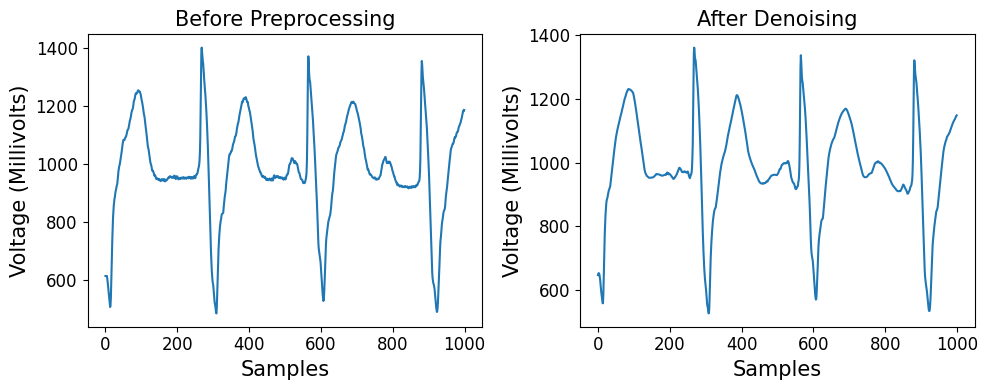

In [15]:
# Plot before preprocessing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(temp_signal[:1000])
plt.title('Before Preprocessing', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage (Millivolts)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot after denoising
plt.subplot(1, 2, 2)
plt.plot(denoised_temp_signal[:1000])
plt.title('After Denoising', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage (Millivolts)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Preprocessing

### Denoising, Scaling, Classes Segmentation

Classes Segmentation

- N: Normal heartbeat.
- V: Premature ventricular contraction.
- A: Atrial fibrillation.
- L: Left bundle branch block.
- R: Right bundle branch block.

In [16]:
# Define classes
classes = ['N', 'L', 'R', 'A', 'V']

# Map classes
class_map = {
    'N': 'Normal heartbeat',
    'L': 'Left bundle branch block',
    'R': 'Right bundle branch block',
    'V': 'Premature ventricular contraction',
    'A': 'Atrial fibrillation',
}

#### Helper functions

In [17]:
def load_signal(file_path):
    """
    Reads the signal data from a CSV file.

    Parameters:
    - file_path: str
        Path to the signal CSV file.

    Returns:
    - signals: list
        List of signal values.
    """
    signals = []
    with open(file_path, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for i, row in enumerate(spamreader):
            if i > 0:  # Skip the header
                signals.append(int(row[1]))
    return signals

In [18]:
def preprocess_signal(signals, denoise_function):
    """
    Preprocesses the signal by denoising and normalizing it.

    Parameters:
    - signals: list
        Original signal values.
    - denoise_function: function
        Function to denoise the signal.

    Returns:
    - preprocessed_signals: list
        Denoised and normalized signal.
    """
    # Denoise the signal
    signals = denoise_function(signals)
    # Normalize the signal using z-score
    preprocessed_signals = stats.zscore(signals)
    return preprocessed_signals

In [19]:
def load_annotations(file_path, classes):
    """
    Reads annotation data and filters valid arrhythmia types.

    Parameters:
    - file_path: str
        Path to the annotations file.
    - classes: list
        List of valid arrhythmia classes.

    Returns:
    - annotations: list of tuples
        Each tuple contains (position, arrhythmia_index).
    """
    annotations = []
    with open(file_path, 'r') as fileID:
        data = fileID.readlines()
        for line in data[1:]:  # Skip the header
            parts = list(filter(None, line.split(' ')))  # Remove empty parts
            pos = int(parts[1])  # Position of the annotation
            arrhythmia_type = parts[2]  # Arrhythmia type
            if arrhythmia_type in classes:
                annotations.append((pos, classes.index(arrhythmia_type)))
    return annotations

In [20]:
def extract_windows(signals, annotations, window_size, count_classes):
    """
    Extracts signal windows centered on annotations.

    Parameters:
    - signals: list
        Preprocessed signal values.
    - annotations: list of tuples
        List of (position, arrhythmia_index).
    - window_size: int
        Half the size of the window to extract.
    - count_classes: list
        Counter for each class occurrence.

    Returns:
    - x: list
        List of extracted signal windows (features).
    - y: list
        List of corresponding labels (targets).
    """
    x, y = [], []
    for pos, arrhythmia_index in annotations:
        # Ensure the window is within signal bounds
        if window_size <= pos < (len(signals) - window_size):
            # Extract the signal window
            window = signals[pos - window_size:pos + window_size]
            x.append(window)
            y.append(arrhythmia_index)
            count_classes[arrhythmia_index] += 1  # Update class count
    return x, y

#### Get Features & Labels

In [21]:
x = list()  # List to store signal windows (features)
y = list()  # List to store corresponding labels (target values)
window_size = 180  # Window size for signal segments (half the segment length)
count_classes = [0] * len(classes)  # Initialize class counters

for r in range(len(records)):
    # Step 1: Load and preprocess the signal
    signals = load_signal(records[r])
    signals = preprocess_signal(signals, denoise)

    # Step 2: Load and filter annotations
    filtered_annotations = load_annotations(annotations[r], classes)

    # Step 3: Extract signal windows
    windows, labels = extract_windows(signals, filtered_annotations, window_size, count_classes)
    x.extend(windows)
    y.extend(labels)

# Final data shape
print(f"Feature shape: {np.shape(x)}, Label shape: {np.shape(y)}")

Feature shape: (100012, 360), Label shape: (100012,)


In [22]:
count_classes

#['N', 'L', 'R', 'A', 'V']

[75011, 8071, 7255, 2546, 7129]

#### Visualize Results

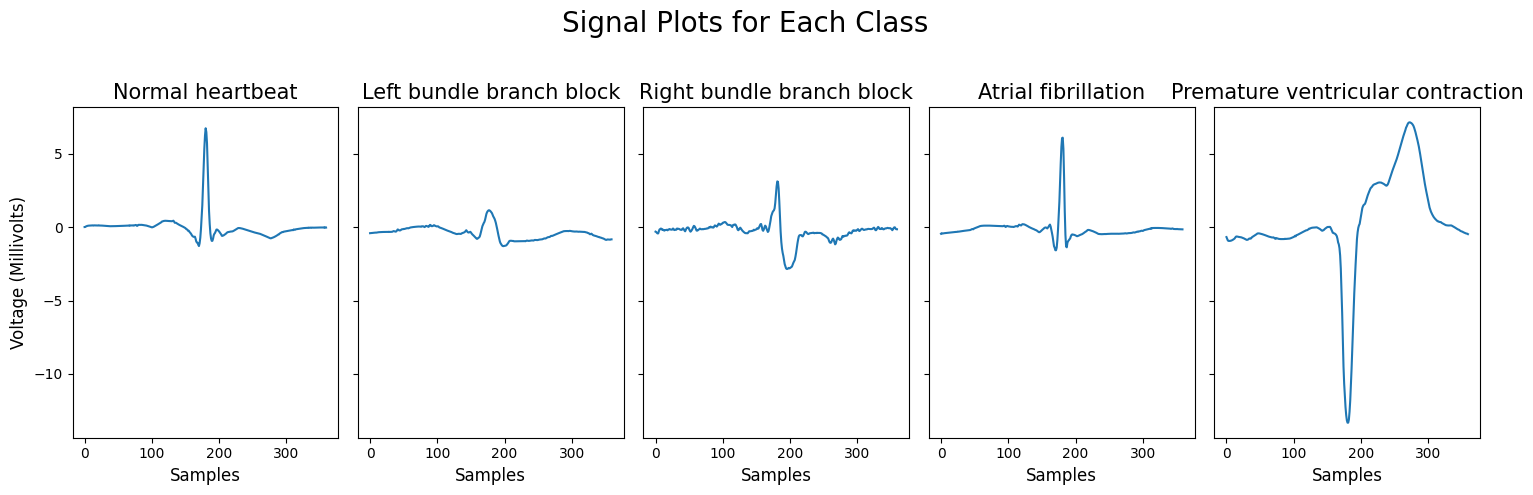

In [23]:
# Set up the number of classes and figure layout
num_classes = len(classes)  # Number of classes to plot
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5), sharey=True)

# Iterate through each class and find the first instance in `y`
for class_index, ax in enumerate(axes):
    i = 0
    while y[i] != class_index:
        i += 1  # Find the first instance of the current class

    # Plot the corresponding signal
    ax.plot(x[i])
    ax.set_title(f'{class_map[classes[class_index]]}', fontsize=15)  # Class name as title
    ax.set_xlabel('Samples', fontsize=12)
    if class_index == 0:  # Label the y-axis only for the first plot
        ax.set_ylabel('Voltage (Millivolts)', fontsize=12)

# Add a global title and adjust layout
plt.suptitle('Signal Plots for Each Class', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

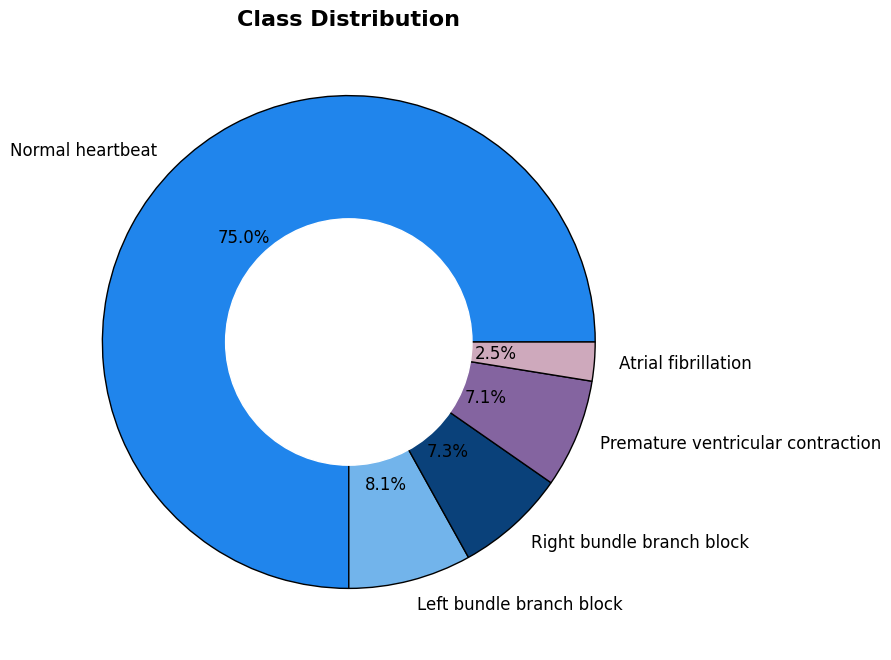

In [24]:
# Convert `y` to a DataFrame for easier handling
y_df = pd.DataFrame(y, columns=["Class"])
per_class = y_df["Class"].value_counts()  # Count occurrences of each class

# Define class labels and colors (ensure they match the indices in `y`)
class_colors = ['#2085ec', '#72b4eb', '#0a417a', '#8464a0', '#cea9bc']

# Create the pie chart
plt.figure(figsize=(12, 8))  # Adjusted size for better fit
plt.pie(
    per_class,
    labels=class_map.values(),  # Use class names as labels
    colors=class_colors,
    autopct='%1.1f%%',  # Display percentages with one decimal
    textprops={'fontsize': 12},  # Font size for text
    wedgeprops={'edgecolor': 'black'}  # Add edge for better distinction
)

# Add a central white circle for a "donut chart" effect
plt.gca().add_artist(plt.Circle((0, 0), 0.5, color='white'))

# Add a meaningful title
plt.title("Class Distribution", fontsize=16, fontweight='bold')

# Display the chart
plt.show()

In [25]:
# Convert x to NumPy array and reshape it
x = np.array(x)  # Convert to NumPy array
x_reshaped = x.reshape(-1, 360)  # Reshape to have 360 samples per window (each row = one signal)
x_df = pd.DataFrame(x_reshaped)  # Convert to DataFrame for easier handling
x_df.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.014193,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140757,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,-0.005353,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.014056,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.024847,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073


In [26]:
# Combine features and labels
x_new_df = pd.concat([x_df, y_df], axis=1)  # Combine features and labels
ax = list(range(361))  # Create column indices (0 to 360, where 360 is the label column)
x_new_df = x_new_df.set_axis(ax, axis='columns')  # Assign column indices
x_new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095,0
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478,0
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259,0
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388,0
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073,0


In [27]:
# Stratified sampling and balancing classes
# Sample majority class and extract other classes
dfs = {}
for class_index in range(num_classes):  # Loop over all classes
    if class_index == 0:  # Downsample the majority class (class 0)
        dfs[class_index] = x_new_df[x_new_df[360] == class_index].sample(n=20000, random_state=42)
    else:  # Upsample the minority classes
        dfs[class_index] = resample(
            x_new_df[x_new_df[360] == class_index],
            replace=True,
            n_samples=7000,
            random_state=42 + class_index  # Unique random state for reproducibility
        )

# Combine all balanced data
x_balanced_df = pd.concat(dfs.values())
x_balanced_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
77042,-1.680959,-1.659245,-1.633256,-1.602367,-1.570746,-1.537908,-1.501199,-1.463844,-1.432589,-1.403449,...,-0.991127,-0.991216,-0.988218,-0.984140,-0.978679,-0.972664,-0.966162,-0.958416,-0.950360,0
51230,-0.292774,-0.268355,-0.242973,-0.218719,-0.194505,-0.166678,-0.138870,-0.111956,-0.086613,-0.070647,...,-0.260494,-0.253279,-0.245243,-0.236866,-0.229991,-0.224125,-0.214610,-0.202842,-0.204465,0
46415,-0.245069,-0.247447,-0.241855,-0.221402,-0.199468,-0.201038,-0.193836,-0.250902,-0.225642,-0.176911,...,-0.148711,-0.126511,-0.142611,-0.161731,-0.153191,-0.192621,-0.153642,-0.106343,-0.131720,0
25690,-0.649717,-0.642706,-0.637089,-0.632181,-0.625337,-0.618411,-0.611368,-0.604798,-0.602013,-0.600907,...,-1.387854,-1.377446,-1.367678,-1.358452,-1.349109,-1.336963,-1.322018,-1.310993,-1.309391,0
32029,-0.174938,-0.170075,-0.183134,-0.166396,-0.176061,-0.163881,-0.164358,-0.154193,-0.155828,-0.144012,...,-0.126126,-0.129452,-0.130908,-0.136692,-0.135770,-0.126619,-0.155829,-0.140649,-0.127331,0


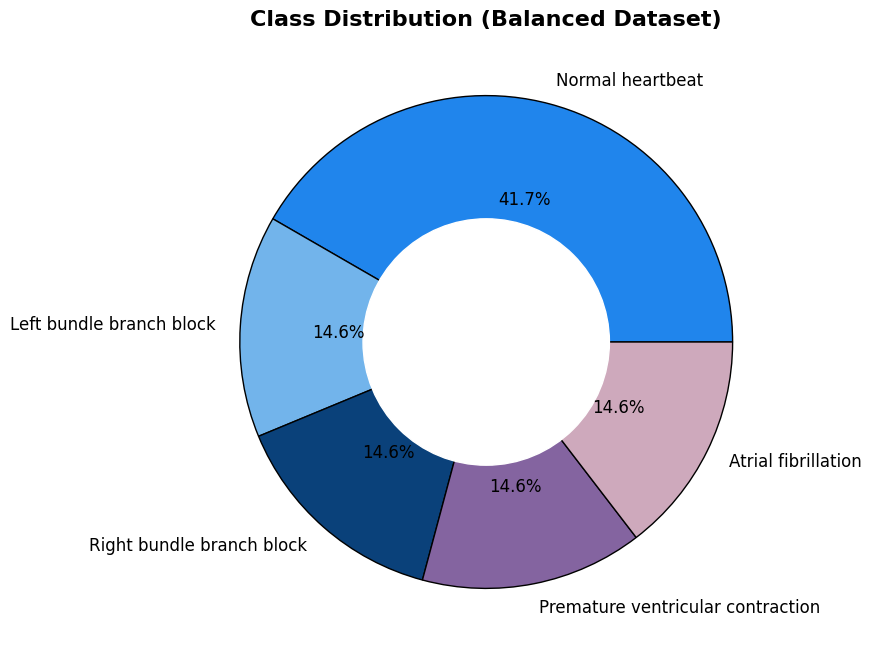

In [28]:
# Plot class distribution as a donut chart
per_class = x_balanced_df[360].value_counts()  # Get class counts

plt.figure(figsize=(12, 8))
plt.pie(
    per_class,
    labels=class_map.values(),  # Class labels
    colors=['#2085ec', '#72b4eb', '#0a417a', '#8464a0', '#cea9bc'],  # Custom colors
    autopct='%1.1f%%',  # Display percentages
    textprops={'fontsize': 12},  # Font size for text
    wedgeprops={'edgecolor': 'black'}  # Add edge for distinction
)
plt.gca().add_artist(plt.Circle((0, 0), 0.5, color='white'))  # Donut effect
plt.title("Class Distribution (Balanced Dataset)", fontsize=16, fontweight='bold')
plt.show()

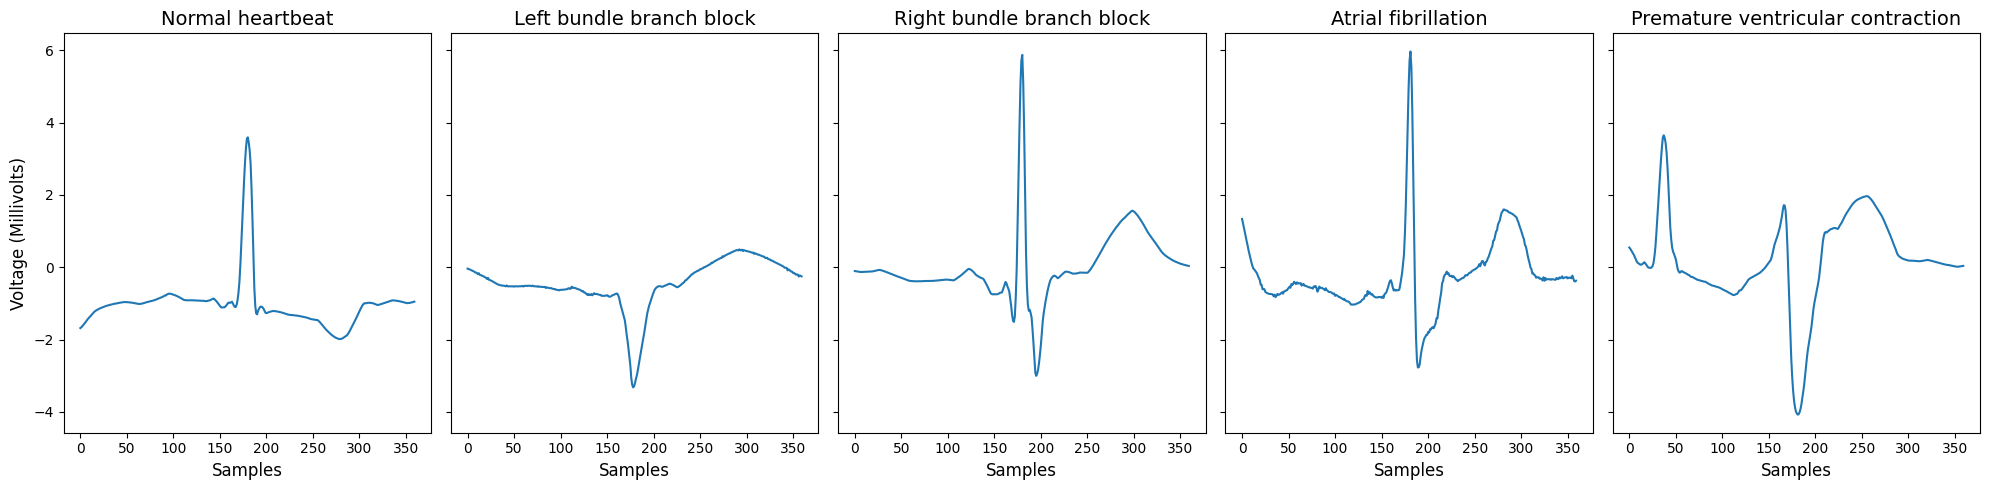

In [29]:
# Extract balanced features and labels from x_balanced_df
x_balanced = x_balanced_df.iloc[:, :360].values # Features
y_balanced = x_balanced_df.iloc[:, 360].values # Labels


# Plot signals for each class side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)  # Create subplots for 5 classes

for class_index, ax in enumerate(axes):
    # Find the first instance of each class in `y_balanced`
    indices = np.where(y_balanced == class_index)[0]

    # Check if indices are found for the class
    if len(indices) > 0:
        idx = indices[0]

        # Plot the signal for the class using x_balanced
        ax.plot(x_balanced[idx])
        ax.set_title(class_map[classes[class_index]], fontsize=14)
        ax.set_xlabel('Samples', fontsize=12)
        if class_index == 0:
            ax.set_ylabel('Voltage (Millivolts)', fontsize=12)
    else:
        print(f"No instances found for class {class_map[classes[class_index]]}")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [30]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),  # Unique class indices
    y=y  # Labels
)
class_weights

array([0.26665956, 2.47830504, 2.75705031, 7.8564022 , 2.80577921])

### Split the dataset into training, validation, and test sets.

We will:
- Shuffle the Data: Randomize the segments to ensure a good mix of data from all files.
- Split Proportions:
  - Training Set: 70% of the data.
  - Validation Set: 15% of the data.
  - Test Set: 15% of the data.

In [31]:
# Split into training (70%) and temporary (30%)
train, temp = train_test_split(x_balanced_df, test_size=0.3, random_state=42, shuffle=True)

# Split temporary set into validation (50% of temp) and test (50% of temp)
validate, test = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)

# Print shapes of resulting splits
print("Training Data Shape:", train.shape)
print("Validation Data Shape:", validate.shape)
print("Test Data Shape:", test.shape)

Training Data Shape: (33600, 361)
Validation Data Shape: (7200, 361)
Test Data Shape: (7200, 361)


In [32]:
# Prepare the target labels
target_train = train[train.shape[1] - 1]  # Extract the last column (class labels) from the train set
target_validate = validate[validate.shape[1] - 1]  # Extract the last column (class labels) from the test set
target_test = test[test.shape[1] - 1]  # Extract the last column (class labels) from the test set

y_train = to_categorical(target_train)  # One-hot encode the training labels
y_validate = to_categorical(target_validate)  # One-hot encode the training labels
y_test = to_categorical(target_test)  # One-hot encode the test labels

print(np.shape(y_train), np.shape(y_validate), np.shape(y_test))  # Print the shapes of the encoded labels

(33600, 5) (7200, 5) (7200, 5)


In [33]:
# Prepare the features
X_train = train.iloc[:, :train.shape[1] - 1].values  # Extract features from the train set
X_validate = validate.iloc[:, :validate.shape[1] - 1].values  # Extract features from the test
X_test = test.iloc[:, :test.shape[1] - 1].values  # Extract features from the test

# Add channel dimmension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(np.shape(X_train), np.shape(X_validate), np.shape(X_test))  # Print the shapes

(33600, 360, 1) (7200, 360, 1) (7200, 360, 1)


## Build and Train the Model

For ECG signal analysis, Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs), such as LSTMs, are commonly utilized. We will adopt the model architecture presented in the paper available at: https://arxiv.org/pdf/2011.06187.

In [44]:
# Define input shape for ECG signal
input_shape = (360, 1)  # Assuming each window has 360 samples and 1 feature/channel

In [45]:
# Define the ECG Input branch
ecg_input = Input(shape=input_shape, name='ecg_input')  # Input for ECG signal
x = Conv1D(filters=32, kernel_size=5, activation='relu')(ecg_input)  # 1D convolution with 32 filters
x = MaxPooling1D(pool_size=2)(x)  # Max pooling to reduce dimensionality
x = Dropout(0.5)(x)  # Dropout for regularization
x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)  # Another 1D convolution with 64 filters
x = MaxPooling1D(pool_size=2)(x)  # Another max pooling layer
x = Dropout(0.5)(x)  # Dropout for further regularization

In [46]:
# Masking Layer
# Masking helps the model ignore padded values in the input (if any)
masked = Masking(mask_value=0.0)(x)

In [47]:
# Recurrent Layers
# Use LSTM layers to process temporal dependencies in the data
# Disable cuDNN by setting use_cudnn to False
x = LSTM(100, return_sequences=True, use_cudnn=False)(masked)  # First LSTM layer, returns sequences
x = LSTM(100, use_cudnn=False)(x)  # Second LSTM layer, returns the final output

In [48]:
# Dense Output Layer
# Fully connected (Dense) layer with softmax activation for classification
output = Dense(5, activation='softmax')(x)  # 5 output classes (e.g., ['N', 'L', 'R', 'V', 'A'])

In [49]:
# Define the Model
model = Model(inputs=ecg_input, outputs=output)

In [50]:
# Compile the Model
# Use Adam optimizer and categorical crossentropy loss for multi-class classification

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [51]:
# Display the model's architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ecg_input (InputLayer)    │ (None, 360, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 356, 32)        │            192 │ ecg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 178, 32)        │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 178, 32)        │              0 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 174, 64)        │         10,304 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 87, 64)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 87, 64)         │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 87, 64)         │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_1 (Masking)       │ (None, 87, 64)         │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_1 (Any)               │ (None, 87)             │              0 │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 87, 100)        │         66,000 │ masking_1[0][0],       │
│                           │                        │                │ any_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 100)            │         80,400 │ lstm_2[0][0],          │
│                           │                        │                │ any_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │            505 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 157,401 (614.85 KB)

 Trainable params: 157,401 (614.85 KB)

 Non-trainable params: 0 (0.00 B)

**Brief Summary of the Model:**

1. **Input**:
   - Accepts 1D ECG signals of shape `(360, 1)` (360 samples, 1 channel).

2. **Feature Extraction**:
   - **Two Conv1D Layers**: Extract low- and high-level spatial features with:
     - 32 filters (first layer) and 64 filters (second layer).
     - Kernel size of 5.
   - **MaxPooling**: Downsamples the temporal dimension to reduce computation.
   - **Dropout**: Prevents overfitting by randomly dropping neurons.

3. **Sequence Learning**:
   - **Two LSTM Layers**: Capture temporal dependencies in the downsampled feature maps.
     - First LSTM outputs sequences, second LSTM outputs a single vector.

4. **Classification**:
   - **Dense Layer**: Outputs probabilities for 5 classes using softmax activation.

5. **Model Parameters**:
   - **Total Parameters**: 157,401.
   - All parameters are trainable.

6. **Key Features**:
   - Combines **CNN** for feature extraction and **LSTM** for temporal analysis.
   - Regularization via Dropout.
   - Suitable for time-series tasks like ECG arrhythmia classification.

In [52]:
# Training Parameters
batch_size = 32
epochs = 20

In [60]:
# try to fit without class weights

# Train the Model
history = model.fit(
    X_train, y_train,  # Training data
    validation_data=(X_validate, y_validate),  # Validation data
    batch_size=batch_size,
    epochs=epochs,
    # class_weight=class_weights_dict,
    verbose=1,  # Displays progress
)

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.9633 - loss: 0.1051 - val_accuracy: 0.9706 - val_loss: 0.0848
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9770 - loss: 0.0618 - val_accuracy: 0.9792 - val_loss: 0.0598
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.9768 - loss: 0.0653 - val_accuracy: 0.9729 - val_loss: 0.0781
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9774 - loss: 0.0650 - val_accuracy: 0.9733 - val_loss: 0.0806
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.9770 - loss: 0.0601 - val_accuracy: 0.9661 - val_loss: 0.1067
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9799 - loss: 0.0589 - val_accuracy: 0.9753 - val_loss: 0.0802
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9808 - loss: 0.0572 - val_accuracy: 0.9789 - val_loss: 0.0664
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9785 -

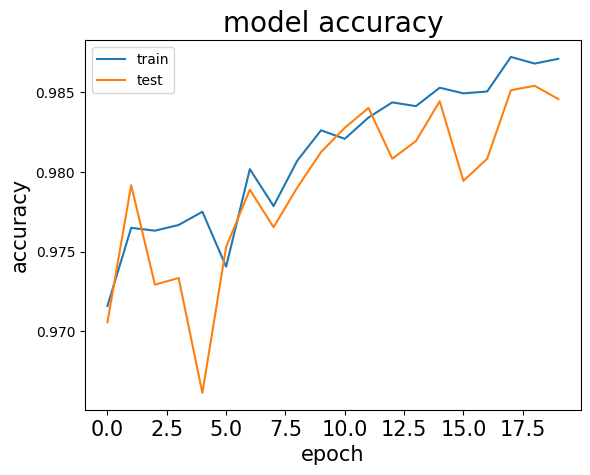

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy',fontsize=20)
plt.xticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_plot')
plt.show()

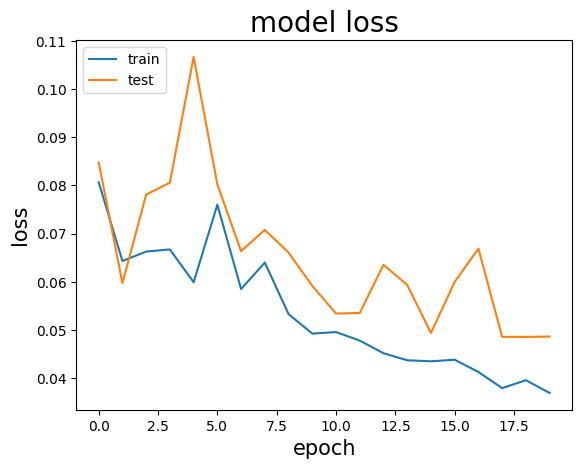

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_plot')
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9854 - loss: 0.0510
Test Accuracy: 0.9869
Test Loss: 0.0418
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


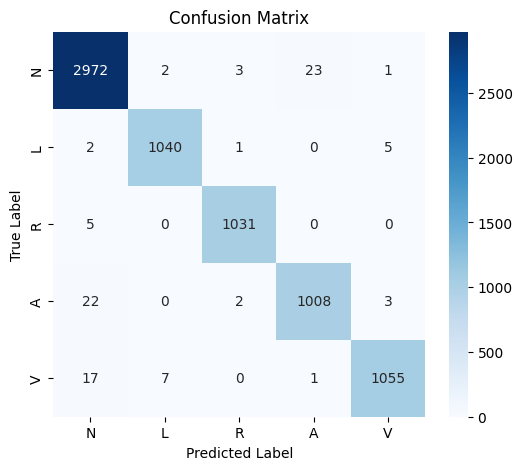

Classification Report:
              precision    recall  f1-score   support

           N       0.98      0.99      0.99      3001
           L       0.99      0.99      0.99      1048
           R       0.99      1.00      0.99      1036
           A       0.98      0.97      0.98      1035
           V       0.99      0.98      0.98      1080

    accuracy                           0.99      7200
   macro avg       0.99      0.99      0.99      7200
weighted avg       0.99      0.99      0.99      7200



In [61]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print test accuracy
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded labels back to class indices
y_true = y_test.argmax(axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

- The model achieved a near-perfect accuracy of 98.69%, meaning it correctly classified almost all ECG segments.
- The low test loss (0.0418) further confirms that the model generalizes well and isn’t just memorizing the training data.
- Precision and Recall are consistently ~99% across all classes, meaning the model isn’t favoring any particular class.
- No major class imbalance issues—each class is being predicted with high reliability.
- No Need for Class Weights: The dataset is already balanced enough, and adding class weights disrupted learning rather than improving it.
- Model is Ready for Deployment: Given the strong generalization, this model is suitable for real-world applications without further modifications.

In [63]:
# Save the trained model in H5 format
model.save("ecg_classification_model.h5")
# Save the trained model in the TensorFlow SavedModel format
model.save("ecg_model.keras")
print("Model saved successfully!")

Model saved successfully!
